In [4]:
import tensorflow as tf
import numpy as np 
import scipy.io.wavfile as wav 
import argparse 
import time                       
import os
import matplotlib.pyplot as plt
import scipy.signal as signal
import librosa
import scipy


In [18]:
class AudioSignal():
    def __init__(self,content,style):
        self.contentFile = content
        self.styleFile = style
        self.N_FFT=2048

    def createSpectrogram(self):

        N_FFT = 2048

        yCont, FScont = librosa.load(self.contentFile)
        ySty, FSsty = librosa.load(self.styleFile)

        contS = librosa.stft(yCont,N_FFT)
        styS = librosa.stft(ySty,N_FFT)
        
        p = np.angle(contS)
        contS = np.log1p(np.abs(contS[:,:430]))
        
        p = np.angle(styS)
        styS = np.log1p(np.abs(styS[:,:430]))
        

        self.num_channels = contS.shape[0]
        self.num_samples = contS.shape[1]

        self.contentSR = FScont
        self.styleSR = FSsty

        self.contentSpec1D = contS
        self.styleSpec1D = styS[:self.num_channels, :self.num_samples]
        
        r,c = self.contentSpec1D.shape
        x = np.zeros(shape=(1,r,c,3))
        y = np.zeros(shape=(1,r,c,3))
        
        for i in range(3):
            x[0,:,:,i] = self.contentSpec1D
            y[0,:,:,i] = self.styleSpec1D
            
        self.contentSpec3D = x
        self.styleSpec3D = y
        
        
    def initSignal(self,typ):
        if typ == 'content':
            self.initialSignal = self.contentSpec3D
        if typ == 'random':
            noise = np.random.uniform(-1.,1., size=self.contentSpec.shape)
            S = librosa.stft(noise,2048)
            p = np.angle(S)
            S = np.log1p(np.abs(S))
            

            self.initialSignal = S


In [3]:
class CNN_VGG():
    def __init__(self,audioModel):
        self.weights = 'imagenet-vgg-verydeep-19.mat'
        self.inputSpec = audioModel.initialSignal
        self.audioModel = audioModel

        self.alpha = 5e0
        self.beta = 1e4
        self.theta = 1e-3

       

    def buildModel(self,num_channels, num_samples):
        #get pre-trained vgg-layer weights
        raw_vgg_net = scipy.io.loadmat(self.weights)
        vgg_layers = raw_vgg_net['layers'][0]
       
        _,h,w,d = self.audioModel.contentSpec3D.shape
        
        net = {}
        pad = 'VALID'
        net['input'] = tf.Variable(np.zeros((1, h, w, d), dtype=np.float32))

        #here using average pooling
        #layer 1
        net['conv1_1'] = tf.nn.conv2d(net['input'], vgg_layers[0][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[0][0][0][2][0][1]
        net['relu1_1'] = tf.nn.relu(net['conv1_1'] + tf.constant(np.reshape(bias,(bias.size))))
 
        net['conv1_2'] = tf.nn.conv2d(net['relu1_1'], vgg_layers[2][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[2][0][0][2][0][1]
        net['relu1_2'] = tf.nn.relu(net['conv1_2'] + tf.constant(np.reshape(bias,(bias.size))))

        #pool 1
        net['pool1'] = tf.nn.avg_pool(net['relu1_2'], ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=pad)

        #layer 2
        net['conv2_1'] = tf.nn.conv2d(net['pool1'], vgg_layers[5][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[5][0][0][2][0][1]
        net['relu2_1'] = tf.nn.relu(net['conv2_1'] + tf.constant(np.reshape(bias,(bias.size))))
 
        net['conv2_2'] = tf.nn.conv2d(net['relu2_1'], vgg_layers[7][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[7][0][0][2][0][1]
        net['relu2_2'] = tf.nn.relu(net['conv2_2'] + tf.constant(np.reshape(bias,(bias.size))))

        #pool 2
        net['pool2'] = tf.nn.avg_pool(net['relu2_2'], ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=pad)

        #layer 3
        net['conv3_1'] = tf.nn.conv2d(net['pool2'],vgg_layers[10][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[10][0][0][2][0][1]
        net['relu3_1'] = tf.nn.relu(net['conv3_1'] + tf.constant(np.reshape(bias,(bias.size))))

        net['conv3_2'] = tf.nn.conv2d(net['relu3_1'],vgg_layers[12][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[12][0][0][2][0][1]
        net['relu3_2'] = tf.nn.relu(net['conv3_2'] + tf.constant(np.reshape(bias,(bias.size))))
        
        net['conv3_3'] = tf.nn.conv2d(net['relu3_2'],vgg_layers[14][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[14][0][0][2][0][1]
        net['relu3_3'] = tf.nn.relu(net['conv3_3'] + tf.constant(np.reshape(bias,(bias.size))))
        
        net['conv3_4'] = tf.nn.conv2d(net['relu3_3'],vgg_layers[16][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[16][0][0][2][0][1]
        net['relu3_4'] = tf.nn.relu(net['conv3_4'] + tf.constant(np.reshape(bias,(bias.size))))
        
        #pool 3
        net['pool3'] = tf.nn.avg_pool(net['relu3_4'], ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=pad)

        #layer 4
        net['conv4_1'] = tf.nn.conv2d(net['pool3'],vgg_layers[19][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[19][0][0][2][0][1]
        net['relu4_1'] = tf.nn.relu(net['conv4_1'] + tf.constant(np.reshape(bias,(bias.size))))

        net['conv4_2'] = tf.nn.conv2d(net['relu4_1'],vgg_layers[21][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[21][0][0][2][0][1]
        net['relu4_2'] = tf.nn.relu(net['conv4_2'] + tf.constant(np.reshape(bias,(bias.size))))
        
        net['conv4_3'] = tf.nn.conv2d(net['relu4_2'],vgg_layers[23][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[23][0][0][2][0][1]
        net['relu4_3'] = tf.nn.relu(net['conv4_3'] + tf.constant(np.reshape(bias,(bias.size))))
        
        net['conv4_4'] = tf.nn.conv2d(net['relu4_3'],vgg_layers[25][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[25][0][0][2][0][1]
        net['relu4_4'] = tf.nn.relu(net['conv4_4'] + tf.constant(np.reshape(bias,(bias.size))))
        
        #pool 4
        net['pool4'] = tf.nn.avg_pool(net['relu4_4'], ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=pad)


        #layer 5
        net['conv5_1'] = tf.nn.conv2d(net['pool4'],vgg_layers[28][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[28][0][0][2][0][1]
        net['relu5_1'] = tf.nn.relu(net['conv5_1'] + tf.constant(np.reshape(bias,(bias.size))))

        net['conv5_2'] = tf.nn.conv2d(net['relu5_1'],vgg_layers[30][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[30][0][0][2][0][1]
        net['relu5_2'] = tf.nn.relu(net['conv5_2'] + tf.constant(np.reshape(bias,(bias.size))))
        
        net['conv5_3'] = tf.nn.conv2d(net['relu5_2'],vgg_layers[32][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[32][0][0][2][0][1]
        net['relu5_3'] = tf.nn.relu(net['conv5_3'] + tf.constant(np.reshape(bias,(bias.size))))
        
        net['conv5_4'] = tf.nn.conv2d(net['relu5_3'],vgg_layers[34][0][0][2][0][0], strides=[1, 1, 1, 1], padding=pad)
        bias =  vgg_layers[34][0][0][2][0][1]
        net['relu5_4'] = tf.nn.relu(net['conv5_4'] + tf.constant(np.reshape(bias,(bias.size))))
        
        #pool 5
        net['pool5'] = tf.nn.avg_pool(net['relu5_4'], ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=pad)

        self.net = net
        return net
    
        
    def content_layer_loss(self,p, x):
        _, h, w, d = p.get_shape()
        M = h.value * w.value
        N = d.value
        K = 1. / (2. * N**0.5 * M**0.5)
        #K = 1. / (N * M)
        #K = 1. / 2.
        loss = K * tf.reduce_sum(tf.pow((x - p), 2))
        return loss

    def style_layer_loss(self,a, x):
        _, h, w, d = a.get_shape()
        M = h.value * w.value
        N = d.value
        A = self.gram_matrix(a, M, N)
        G = self.gram_matrix(x, M, N)
        loss = (1./(4 * N**2 * M**2)) * tf.reduce_sum(tf.pow((G - A), 2))
        return loss

    def gram_matrix(self,x, area, depth):
        F = tf.reshape(x, (area, depth))
        G = tf.matmul(tf.transpose(F), F)
        return G


    def styleLoss(self,sess):
        styleSpec = self.audioModel.styleSpec3D
        net = self.net
        
        sess.run(net['input'].assign(styleSpec))
        styleloss = 0.
        styleLayersVGG = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
        styleLayerWeights = [0.2, 0.2, 0.2, 0.2, 0.2] #equal weighting to all 5

        for layer, weight in zip(styleLayersVGG, styleLayerWeights):
            a = sess.run(net[layer])
            x = net[layer]
            a = tf.convert_to_tensor(a)
            styleloss += self.style_layer_loss(a, x) * weight

        styleloss /= float(len(styleLayersVGG))
        return styleloss

    def contentLoss(self,sess):
        contentSpec = self.audioModel.contentSpec3D
        net = self.net
        sess.run(net['input'].assign(contentSpec))     
        
        #content layers is conv4_2
        contentLayer = 'conv4_2'
        contentLayerWeight = 1.0
        
        p = sess.run(net[contentLayer])
        x = net[contentLayer]
        p = tf.convert_to_tensor(p)
        content_loss = self.content_layer_loss(p, x) * contentLayerWeight
        
        return content_loss

    def minimizeLBGFS(self,sess,optimizer):
        print('\nMINIMIZING LOSS USING: L-BFGS OPTIMIZER')
        initSpec = self.audioModel.initialSignal

        initOp = tf.global_variables_initializer()
        sess.run(initOp)
        sess.run(self.net['input'].assign(initSpec))
        optimizer.minimize(sess)

    def convertOutput(self,result):
        N_FFT=2048
        
        print result[0].shape
        
        flattenresult = np.mean(result[0],axis=2)
        
        print flattenresult.shape
        
        
        a = np.zeros_like(flattenresult)
        a[:self.audioModel.num_channels,:] = np.exp(flattenresult[0,0].T) - 1

        # This code is supposed to do phase reconstruction
        p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
        for i in range(500):
            S = a * np.exp(1j*p)
            x = librosa.istft(S)
            p = np.angle(librosa.stft(x, N_FFT))
            
        OUTPUT_FILENAME = 'result.wav'
        librosa.output.write_wav(OUTPUT_FILENAME, x, self.audioModel.contentSR)


    def run(self):
        graph = tf.Graph()

        with tf.Graph().as_default(), tf.device('/gpu:0'), tf.Session() as sess: #starting tensor flow
            self.buildModel(self.audioModel.num_channels,self.audioModel.num_samples)

            #self.net is the network
            LossStyle = self.styleLoss(sess)
            LossContent = self.contentLoss(sess)

            L_tv = tf.image.total_variation(self.net['input'])

            LossTotal  = self.alpha * LossContent
            LossTotal += self.beta  * LossStyle
            LossTotal += self.theta * L_tv

            #optimizer = lgbfs

            maxIterations = 1000
            optimizerLBFGS = tf.contrib.opt.ScipyOptimizerInterface(
                LossTotal, method='L-BFGS-B',
                options={'maxiter': maxIterations,
                         'disp': 0})

            self.minimizeLBGFS(sess,optimizerLBFGS)

            outputSpec = sess.run(self.net['input'])
            outputSignal = self.convertOutput(outputSpec)



In [28]:
class CNN_Shallow():
    
    def __init__(self,audioModel):
        self.audioModel = audioModel
        self.alpha = 1e-2
        self.beta = 1
        self.learningrate = 1e-3
        self.iterations = 100 
        
        self.numfilters = 4096
        
    def runModel(self):
        audioModel = self.audioModel
        
        content = audioModel.contentSpec1D
        style = audioModel.styleSpec1D
        
        contentTf = np.ascontiguousarray(content.T[None,None,:,:])
        styleTf = np.ascontiguousarray(style.T[None,None,:,:])
        
        std = np.sqrt(2) * np.sqrt(2.0 / ((audioModel.num_channels + self.numfilters) * 11))
        kernel = np.random.randn(1, 11, audioModel.num_channels, self.numfilters)*std
        
        g = tf.Graph()
        with g.as_default(), g.device('/gpu:0'), tf.Session() as sess:
            x = tf.placeholder('float32', [1,1,audioModel.num_samples,audioModel.num_channels], name="x")
            
            
            kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
            conv = tf.nn.conv2d(x,kernel_tf,strides=[1, 1, 1, 1],padding="VALID",name="conv")
    
            net = tf.nn.relu(conv)
        
            content_features = net.eval(feed_dict={x: contentTf})
            style_features = net.eval(feed_dict={x: styleTf})
    
            features = np.reshape(style_features, (-1, self.numfilters))
            style_gram = np.matmul(features.T, features) / audioModel.num_samples

        with tf.Graph().as_default():   
            
            x = tf.Variable(np.random.randn(1,1,audioModel.num_samples,audioModel.num_channels).astype(np.float32)*1e-3, name="x")
            
            kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
            conv = tf.nn.conv2d(x,kernel_tf,strides=[1, 1, 1, 1],padding="VALID",name="conv")
    
            net = tf.nn.relu(conv)
        
            content_loss = self.alpha * 2 * tf.nn.l2_loss( net - content_features)
    
            style_loss = 0
            _, height, width, number = map(lambda i: i.value, net.get_shape())
            size = height * width * number
            
            feats = tf.reshape(net, (-1, number))
            gram = tf.matmul(tf.transpose(feats), feats)  / audioModel.num_samples
            style_loss = 2 * tf.nn.l2_loss(gram - style_gram)
            
            loss = content_loss + style_loss
            
            opt = tf.contrib.opt.ScipyOptimizerInterface(loss, method='L-BFGS-B', options={'maxiter': 300})
            
            with tf.Session() as sess:
                sess.run(tf.initialize_all_variables())
       
                print('Started optimization.')
                opt.minimize(sess)
    
                print 'Final loss:', loss.eval()
                result = x.eval()
            
            self.result = result
            
    def postprocess(self):
        N_FFT = 2048
        audioModel = self.audioModel

        content = audioModel.contentSpec1D
        
        a = np.zeros_like(content)
        a[:audioModel.num_channels,:] = np.exp(self.result[0,0].T) - 1


        p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
        for i in range(500):
            S = a * np.exp(1j*p)
            x = librosa.istft(S)
            p = np.angle(librosa.stft(x, N_FFT))

        OUTPUT_FILENAME = 'audio_output/resultShallow6.wav'
        librosa.output.write_wav(OUTPUT_FILENAME, x, audioModel.styleSR)
        
    def run(self):
        self.runModel()
        self.postprocess()
        
        
        
            

In [29]:
def runNetwork():

    contentfile = 'audio_input/imperial.mp3'
    stylefile = 'audio_input/usa.mp3'
    
    audioModel = AudioSignal(contentfile,stylefile)
    audioModel.createSpectrogram()
    #audioModel.initSignal('content')

    #CNNVGG_model = CNN_VGG(audioModel)
    CNNShallow_model = CNN_Shallow(audioModel)
    CNNShallow_model.run()
    #CNNVGG_model.run()
    #return audioModel


In [30]:
audioModel = runNetwork()

(1025, 430)
(1025, 430)
Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT
  Objective function value: 560.033264
  Number of iterations: 301
  Number of functions evaluations: 323
Final loss: 560.03326


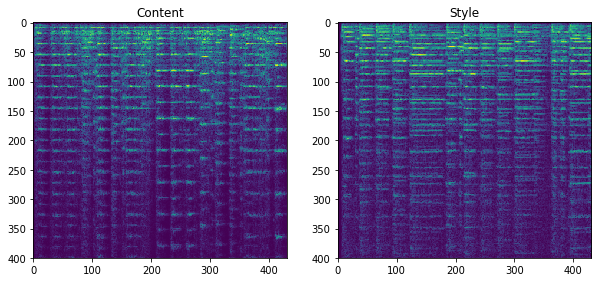

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(audioModel.contentSpec[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(audioModel.styleSpec[:400,:])
plt.show()

In [12]:
from IPython.display import Audio, display

display(Audio('resultShallow.wav'))

In [31]:
display(Audio('audio_output/resultShallow6.wav'))